In [83]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/drive/MyDrive/RNN_FPT/ACB Historical Data.csv')
df1=df.reset_index()['Price']

In [140]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [141]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [142]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [143]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [144]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [145]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [146]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
5/5 [==============================] - 2s 78ms/step - loss: 0.1761 - val_loss: 0.1361
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0310 - val_loss: 0.0699
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0122 - val_loss: 0.0202
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0089 - val_loss: 0.0647
Epoch 5/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0104 - val_loss: 0.0420
Epoch 6/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0055 - val_loss: 0.0197
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0305
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0056 - val_loss: 0.0342
Epoch 9/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0046 - val_loss: 0.0193
Epoch 10/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0216
Epoch 11/100
5/5 [=

In [147]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 13ms/step


In [148]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [149]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 25039.20324982534
Testing RMSE: 21840.580331380006


In [150]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[-50:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=50
i=0
while(i<30):
    
    if(len(temp_input)>50):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.5785103]
51
1 day input [0.548      0.508      0.568      0.572      0.548      0.532
 0.536      0.528      0.532      0.504      0.52       0.516
 0.496      0.536      0.536      0.54       0.528      0.536
 0.544      0.588      0.588      0.576      0.6        0.564
 0.576      0.56       0.568      0.564      0.572      0.564
 0.568      0.552      0.528      0.512      0.512      0.512
 0.5        0.504      0.504      0.512      0.528      0.54
 0.584      0.564      0.56       0.564      0.592      0.576
 0.568      0.57851028]
1 day output [[0.5758879]]
2 day input [0.508      0.568      0.572      0.548      0.532      0.536
 0.528      0.532      0.504      0.52       0.516      0.496
 0.536      0.536      0.54       0.528      0.536      0.544
 0.588      0.588      0.576      0.6        0.564      0.576
 0.56       0.568      0.564      0.572      0.564      0.568
 0.552      0.528      0.512      0.512      0.512      0.5
 0.504      0.504      0.512      0.528      

Validation RMSE: 25039.20324982534
Testing RMSE: 21840.580331380006


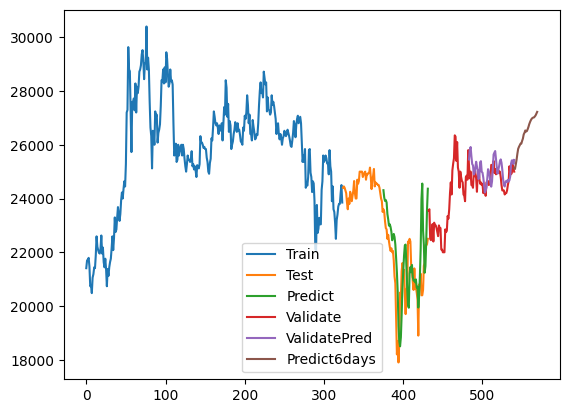

[[0.5785102844238281], [0.57588791847229], [0.5894061326980591], [0.603230357170105], [0.6208221912384033], [0.6356679797172546], [0.6416443586349487], [0.6464079022407532], [0.6512291431427002], [0.6513749361038208], [0.6593943238258362], [0.6664847135543823], [0.6787269115447998], [0.6836934685707092], [0.6905563473701477], [0.6871954798698425], [0.6887539029121399], [0.6942590475082397], [0.7010884284973145], [0.7092685699462891], [0.7155941724777222], [0.7209888696670532], [0.7250016331672668], [0.7275898456573486], [0.7288429737091064], [0.7293670773506165], [0.7321423292160034], [0.7354597449302673], [0.7405638098716736], [0.7458192110061646]]


In [151]:
# 14.Vẽ hình
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+51, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+51, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict6days'])
plt.show()
print(lst_output)

In [152]:
scaler.inverse_transform(lst_output)[:6, 0]

array([25131.3785553 , 25098.5989809 , 25267.57665873, 25440.37946463,
       25660.27739048, 25845.84974647])